In [1]:
import sys
import math
MAX = sys.maxsize

import matplotlib.pyplot as plt

In [2]:
class Activity:
    # define activity class
    def __init__(self, aname, duration, predecessors):
        self.aname = aname
        self.duration = duration
        self.predecessors = predecessors
        self.successors = []
        self.earlytime = MAX
        self.latetime = MAX
        self.etfound = False
        self.ltfound = False
        self.float = MAX
 
    def __str__(self):
        return self.aname + ' depend on ' + str([x for x in self.predecessors])
    
    def getName(self):
        return self.aname
    
    def addPred(self, pred):
        if pred not in self.predecessors:
            self.predecessors.append(pred)

    def addSucc(self, succ):
        if succ not in self.successors:
            self.successors.append(succ) 
    
    def getEarlyTime(self):
        return self.earlytime
    
    def getLateTime(self):
        return self.latetime
    
    def setEarlyTime(self, t):
        self.earlytime = t
        
    def setLateTime(self, t):
        self.latetime = t
        
    def getPreds(self):
        return self.predecessors
    
    def getSuccs(self):
        return self.successors

In [3]:
class Network():
    # define critical network class
    def __init__(self):
        self.alist = {}
        self.completetime = 0
        
    def __contains__(self, aname):
        # check if a vertex is in the graph
        return aname in self.alist
    
    def __iter__(self):
        # iterate over vertices as Vertex Class objects
        return iter(self.alist.values())
    
    def getActivity(self, aname):
        return self.alist[aname]
    
    def getAllSucc(self, aname):
        # return all successive activities for one particular activity
        succlist = []
        for sname in self.getActivity(aname).getSuccs():
            if sname not in succlist:
                succlist.append(sname)
            if self.getActivity(sname).getSuccs() != None:
                furthersuccs = self.getAllSucc(sname)
                for fsname in furthersuccs:
                    if fsname not in succlist:
                        succlist.append(fsname)
        return succlist
    
    def getAllPred(self, aname):
        # return all preceeding activities for one particular activity
        predlist = []
        for pname in self.getActivity(aname).getPreds():
            if pname not in predlist:
                predlist.append(pname)
            if self.getActivity(pname).getPreds() != None:
                furtherpreds = self.getAllPred(pname)
                for fpname in furtherpreds:
                    if fpname not in predlist:
                        predlist.append(fpname)
        return predlist
    
    def addActivity(self, aname, duration, predecessors):
        self.alist[aname] = Activity(aname, duration, predecessors)
        for pred in predecessors:
            if pred not in self.alist:
                self.alist[pred] = Activity(pred, 0, [])
            self.getActivity(pred).addSucc(aname)
                
    def findEarlyTime(self, aname):
        currentActivity = self.getActivity(aname)
        if not currentActivity.etfound:
            preds = currentActivity.getPreds()
            if len(preds) == 0:
                currentActivity.earlytime = 0
            else:
                times = []
                for pred in preds:
                    predact = self.getActivity(pred)
                    if not predact.etfound:
                        self.findEarlyTime(pred)
                    times.append(predact.earlytime + predact.duration)
                currentActivity.earlytime = max(times)
        return currentActivity.earlytime
    
    def findLateTime(self, aname):
        currentActivity = self.getActivity(aname)
        if not currentActivity.ltfound:
            succs = currentActivity.getSuccs()
            if len(succs) == 0:
                currentActivity.latetime = self.completetime
            else:
                times = []
                for succ in succs:
                    succact = self.getActivity(succ)
                    if not succact.ltfound:
                        self.findLateTime(succ)
                    times.append(succact.latetime - succact.duration)
                currentActivity.latetime = min(times)
        return currentActivity.latetime
    
    def solve(self, needprint=True):
        # solve the early times and the late times for all activities in the critical network
        # print out the results as a table if needed

        # reset all early times and all late times in case there is any update for the network
        for a in self:
            a.earlytime = MAX
            a.latetime = MAX
            a.etfound = False
            a.ltfound = False
        
        # perform forward pass, find all early start times
        complete_times = []
        for a in self:
            aname = a.getName()
            self.findEarlyTime(aname)
            complete_times.append(a.earlytime + a.duration)
        self.completetime = max(complete_times)
        
        if needprint:
            print('%10s %10s %12s %12s %12s %22s' 
                  %('Activity', 'Duration', 'Early Start', 'Late Finish', 
                    'Total Float', 'Preceeding Activities'))
        
        # perform backward pass, find all late finsih times and total floats
        criticals = []
        for a in self:
            aname = a.getName()
            self.findLateTime(aname)
            a.float = a.latetime - a.earlytime - a.duration
            if needprint:
                print('%6s %11s %11s %12s %11s %5s %-12s' 
                      %(aname, a.duration, a.earlytime, a.latetime, a.float, '', a.predecessors))
            # check if the activity is critical
            if a.float == 0:
                criticals.append(aname)
        
        if needprint:
            print('\nCritical activities are:', criticals)
            print('Minimum completion time for this network:', self.completetime)
    
    def gantt(self):
        # plot gantt diagram (also known as cascade diagram) for the project
        # critical activities are plotted in red
        # non-critical activities are plotted in blue
        # total float for non-critical activites are plotted in light green
        plt.figure(figsize=(10,5))
        plt.title('Gantt Diagram', size=18)
    
        self.solve(False)
        for a in self:
            if a.float == 0:
                plt.barh(y=a.getName(), left=a.earlytime, width=a.duration, 
                 alpha=0.8, color='red', label='Critical')
            else:
                plt.barh(y=a.getName(), left=a.earlytime, width=a.duration, 
                 alpha=0.7, color='blue', label='Non-critical')
                plt.barh(y=a.getName(), left=a.earlytime+a.duration, width=a.float, 
                 alpha=0.3, color='green')

        plt.gca().invert_yaxis()
        plt.grid(axis='x')
        handles, labels = plt.gca().get_legend_handles_labels()
        handle_list, label_list = [], []
        for handle, label in zip(handles, labels):
            if label not in label_list:
                handle_list.append(handle)
                label_list.append(label)
        plt.legend(handle_list, label_list, fontsize='large')
        plt.xticks(range(0, self.completetime+1), fontsize='medium')
        plt.ylabel('Activities', fontsize='large')
        plt.xlabel('Time', fontsize='large')
        plt.show()
    
    def workersByCalc(self):
        self.solve(False)
        total = 0
        for a in self:
            total += a.duration
        print('Sum of duration for all activities = ', total)
        print('Minimum completion time for the project = ', self.completetime)
        print(total, '/', self.completetime, '≈', round(total/self.completetime, 2))
        print('So at least ', math.ceil(total/self.completetime), ' workers needed.')
        return math.ceil(total/self.completetime)
    
    def workersByGantt(self):
        self.solve(False)
        num = 0
        s = 0
        for t in range(0, self.completetime):
            numCurrent = 0
            p = []
            for a in self:
                if t+0.5 > a.latetime - a.duration and t+0.5 < a.earlytime + a.duration:
                    numCurrent += 1
                    p.append(a.aname)
            if numCurrent > num:
                num = numCurrent
                s = t
                ongoing = p
        print('During ', s, '< t < ', s+1, ', there are activities: ', ongoing)
        print('Minimum number of workers for this project is:', num)
        return num


## Example 1

Question from Pearson Edexcel Past Papers 

WDM11/01 October 2020

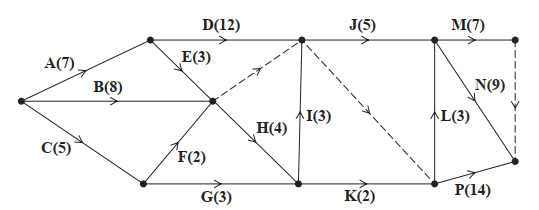

In [4]:
g = Network()

g.addActivity('A', 7, [])
g.addActivity('B', 8, [])
g.addActivity('C', 5, [])
g.addActivity('D', 12, ['A'])
g.addActivity('E', 3, ['A'])
g.addActivity('F', 2, ['C'])
g.addActivity('G', 3, ['C'])
g.addActivity('H', 4, ['B', 'E', 'F'])
g.addActivity('I', 3, ['G', 'H'])
g.addActivity('J', 5, ['B', 'D', 'E', 'F', 'I'])
g.addActivity('K', 2, ['G', 'H'])
g.addActivity('L', 3, ['B', 'D', 'E', 'F', 'I', 'K'])
g.addActivity('M', 7, ['J', 'L'])
g.addActivity('N', 9, ['J', 'L'])
g.addActivity('P', 14, ['B', 'D', 'E', 'F', 'I', 'K'])

In [5]:
g.solve()

  Activity   Duration  Early Start  Late Finish  Total Float  Preceeding Activities
     A           7           0            7           0       []          
     B           8           0           12           4       []          
     C           5           0           10           5       []          
     D          12           7           19           0       ['A']       
     E           3           7           12           2       ['A']       
     F           2           5           12           5       ['C']       
     G           3           5           16           8       ['C']       
     H           4          10           16           2       ['B', 'E', 'F']
     I           3          14           19           2       ['G', 'H']  
     J           5          19           24           0       ['B', 'D', 'E', 'F', 'I']
     K           2          14           19           3       ['G', 'H']  
     L           3          19           24           2       ['B', 'D', 'E

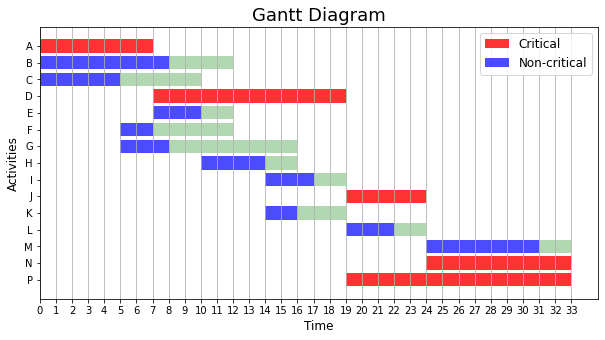

In [6]:
g.gantt()

In [7]:
g.workersByGantt()

During  21 < t <  22 , there are activities:  ['J', 'L', 'P']
Minimum number of workers for this project is: 3


3

## Example 2

Question from Pearson Edexcel Past Papers

WDM11/01 Summer 2021

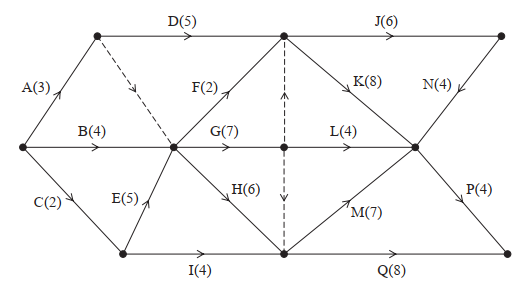

In [8]:
h = Network()

h.addActivity('A', 3, [])
h.addActivity('B', 4, [])
h.addActivity('C', 2, [])
h.addActivity('D', 5, ['A'])
h.addActivity('E', 5, ['C'])
h.addActivity('F', 2, ['A', 'B', 'E'])
h.addActivity('G', 7, ['A', 'B', 'E'])
h.addActivity('H', 6, ['A', 'B', 'E'])
h.addActivity('I', 4, ['C'])
h.addActivity('J', 6, ['D', 'F', 'G'])
h.addActivity('K', 8, ['D', 'F', 'G'])
h.addActivity('L', 4, ['G'])
h.addActivity('M', 7, ['G', 'H', 'I'])
h.addActivity('N', 4, ['J'])
h.addActivity('P', 4, ['K', 'L', 'M', 'N'])
h.addActivity('Q', 8, ['G', 'H', 'I'])

In [9]:
h.solve()

  Activity   Duration  Early Start  Late Finish  Total Float  Preceeding Activities
     A           3           0            7           4       []          
     B           4           0            7           3       []          
     C           2           0            2           0       []          
     D           5           3           14           6       ['A']       
     E           5           2            7           0       ['C']       
     F           2           7           14           5       ['A', 'B', 'E']
     G           7           7           14           0       ['A', 'B', 'E']
     H           6           7           17           4       ['A', 'B', 'E']
     I           4           2           17          11       ['C']       
     J           6          14           20           0       ['D', 'F', 'G']
     K           8          14           24           2       ['D', 'F', 'G']
     L           4          14           24           6       ['G']       
 

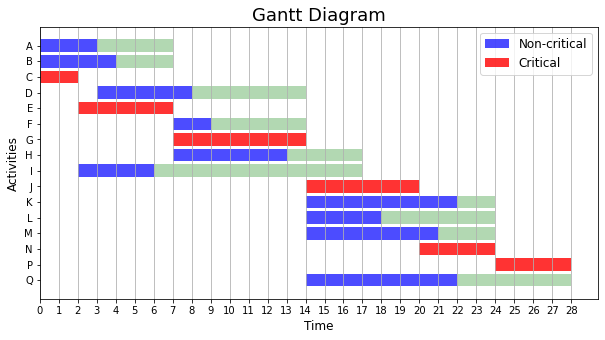

In [10]:
h.gantt()

In [11]:
h.workersByGantt()

During  20 < t <  21 , there are activities:  ['K', 'M', 'N', 'Q']
Minimum number of workers for this project is: 4


4

## Example 3

Question from Pearson Edexcel Past Papers

WDM11/11 Summer 2023

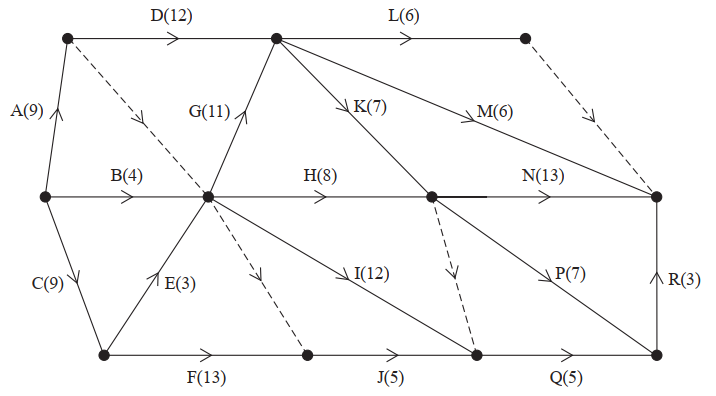

In [12]:
k = Network()

k.addActivity('A', 9, [])
k.addActivity('B', 4, [])
k.addActivity('C', 9, [])
k.addActivity('D', 12, ['A'])
k.addActivity('E', 3, ['C'])
k.addActivity('F', 13, ['C'])
k.addActivity('G', 11, ['A', 'B', 'E'])
k.addActivity('H', 8, ['A', 'B', 'E'])
k.addActivity('I', 12, ['A', 'B', 'E'])
k.addActivity('J', 5, ['A', 'B', 'E', 'F'])
k.addActivity('K', 7, ['D', 'G'])
k.addActivity('L', 6, ['D', 'G'])
k.addActivity('M', 6, ['D', 'G'])
k.addActivity('N', 13, ['H', 'K'])
k.addActivity('P', 7, ['H', 'K'])
k.addActivity('Q', 5, ['H', 'K', 'I', 'J'])
k.addActivity('R', 3, ['P', 'Q'])

In [13]:
k.solve()

  Activity   Duration  Early Start  Late Finish  Total Float  Preceeding Activities
     A           9           0           11           2       []          
     B           4           0           12           8       []          
     C           9           0            9           0       []          
     D          12           9           23           2       ['A']       
     E           3           9           12           0       ['C']       
     F          13           9           30           8       ['C']       
     G          11          12           23           0       ['A', 'B', 'E']
     H           8          12           30          10       ['A', 'B', 'E']
     I          12          12           35          11       ['A', 'B', 'E']
     J           5          22           35           8       ['A', 'B', 'E', 'F']
     K           7          23           30           0       ['D', 'G']  
     L           6          23           43          14       ['D', 'G']  

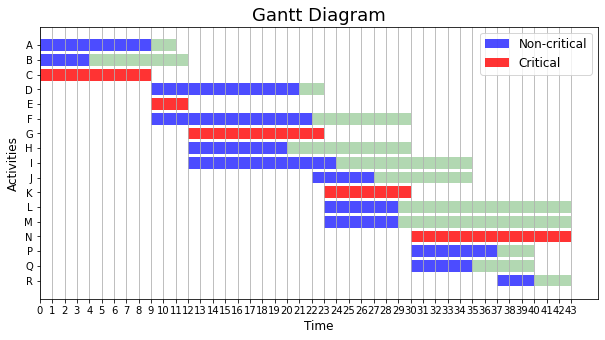

In [14]:
k.gantt()

In [15]:
k.workersByCalc()

Sum of duration for all activities =  133
Minimum completion time for the project =  43
133 / 43 ≈ 3.09
So at least  4  workers needed.


4

In [16]:
k.workersByGantt()

During  17 < t <  18 , there are activities:  ['D', 'F', 'G']
Minimum number of workers for this project is: 3


3